In [1]:
# general imports
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *
from helper.preprocess import *

# ML
from sklearn.decomposition import NMF


# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\walke\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
meta_df = getDF('../../data/meta_Health_and_Personal_Care.json.gz')

In [3]:
meta_df.head(2)

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0077614992,This is an example product description.,Principles of Mgmt + Oper-CSUF Custom C,http://ecx.images-amazon.com/images/I/51G%2BRq...,"{'also_bought': ['0471730726', '0132834871', '...",{'Health & Personal Care': 168429},[[Health & Personal Care]],NaN,NaN
1,0615208479,By now we all know the benefits of exercise fo...,Brain Fitness Exercises Software,http://ecx.images-amazon.com/images/I/41kbZB04...,NaN,{'Health & Personal Care': 1346973},"[[Health & Personal Care, Personal Care]]",NaN,NaN


In [4]:
health_df = getDF('../../data/reviews_Health_and_Personal_Care_5.json.gz')

In [5]:
health_df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"


In [4]:
merged_df = preprocess_pipeline(health_df, meta_df).prep()

NameError: name 'health_df' is not defined

#### Basic Preprocessing and Feature Engineering

##### Feature Engineering using NMF to understand customer categories
* having deeper insight into customer groups allows us to better deal with the cold start problem

In [9]:
# set review count column for easy NMF
merged_df['review_count'] = 1

# sparse matrix, with rows as users, columns as categories, values as reviewed
sparse_df = merged_df.pivot_table(values='review_count', index='reviewerID', 
                      columns='categories', fill_value=0)


# set NMF compoents, I select 10 as this seems to give a good number of distinct categories
nmf = NMF(n_components=10)
nmf.fit(sparse_df)
W = nmf.transform(sparse_df)
H = nmf.components_

# set as dataframes for easy exploration
W = pd.DataFrame(W, index=sparse_df.index.tolist())
H = pd.DataFrame(H, columns=sparse_df.columns.tolist())


# here is where the work is manual and needs judgement
# I use the display function to go through each category and set a more distinct name, these are the 10 I have selected
categories = ['alergy', 'deoderant', 'shaving', 'massage', 'protien_supplements', 'vitamins', 'prenatal', 'weight_loss', 'scale', 'laundry']
# top_cats = H.iloc[9].sort_values(ascending=False).index[:3]
# display(top_cats)


# now to select all unique users
cust_list = merged_df.reviewerID.unique().tolist()

# populate a category dictionary to reference to 
cat_dict = {0:'alergy', 1:'deoderant', 2:'shaving', 3:'massage', 4:'protien_supplements', 5:'vitamins', 6:'prenatal', 7:'weight_loss', 8:'scale', 9:'laundry'}

# set default dict to populate with reviewerid and category
cust_dict = defaultdict(str)

In [ ]:
# now to select all unique users
cust_list = merged_df.reviewerID.unique().tolist()

# populate a category dictionary to reference to 
cat_dict = {0:'alergy', 1:'deoderant', 2:'shaving', 3:'massage', 4:'protien_supplements', 5:'vitamins', 6:'prenatal', 7:'weight_loss', 8:'scale', 9:'laundry'}

# set default dict to populate with reviewerid and category
cust_dict = defaultdict(str)


def get_category(cust_list, cat_dict, cust_dict):
    
    """
    populates dictionary with reviewerID and top category for user
    
    Arguments
    ---------
    
    cust_list: list, a unique list of all current reviewerIDs
    
    cat_dict: dictionary, a dictionary populated with user input categories,
        this needs to be done manually
    
    cust_dict: Empty default dictionary to be populated
    """
    # copy dictionaries
    cat_dict = cat_dict.copy()
    cust_dict = cust_dict.copy()
    
    # loop through all customers and populate dictionary
    for cust in cust_list:
        nmf_cat = W.loc[cust].sort_values(ascending=False).index[0] # select top value inside W matrix per user
        true_cat = cat_dict[nmf_cat]

        cust_dict[cust] = true_cat
        
    return cust_dict


In [ ]:
populated_dict = get_category(cust_list, cat_dict, cust_dict)

# map dictionary category to user for new column
merged_df['reviewer_cat'] = merged_df['reviewerID'].apply(lambda x: populated_dict[x])

In [2]:
# merged_df.to_csv(r'../../merged_df.csv', index=False)
merged_df = pd.read_csv('../../merged_df.csv')

#### Exploratory Data Analysis

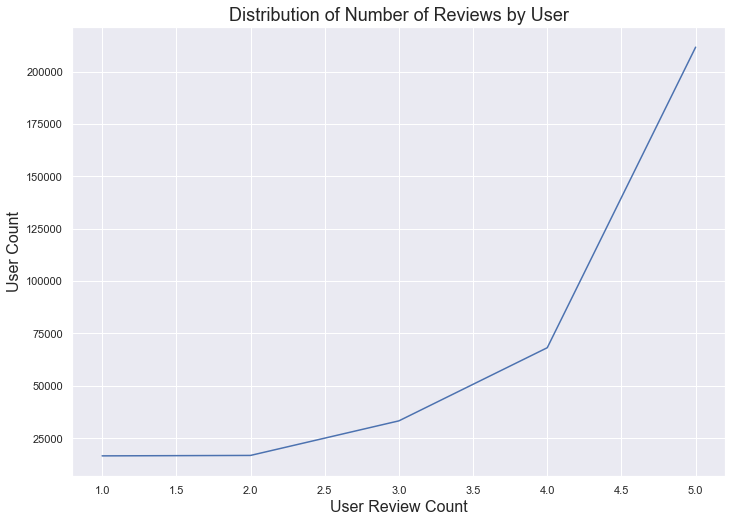

In [6]:
#  Distribution of Reviews

review_distribution = merged_df.overall.value_counts()

figure = sns.lineplot(x=review_distribution.index, y = review_distribution.values)
plt.title('Distribution of Number of Reviews by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('User Review Count', fontsize=16)
plt.ylabel('User Count', fontsize=16)
# plt.savefig(r"../images/dist_of_reviews_2");

Text(0, 0.5, 'User Count')

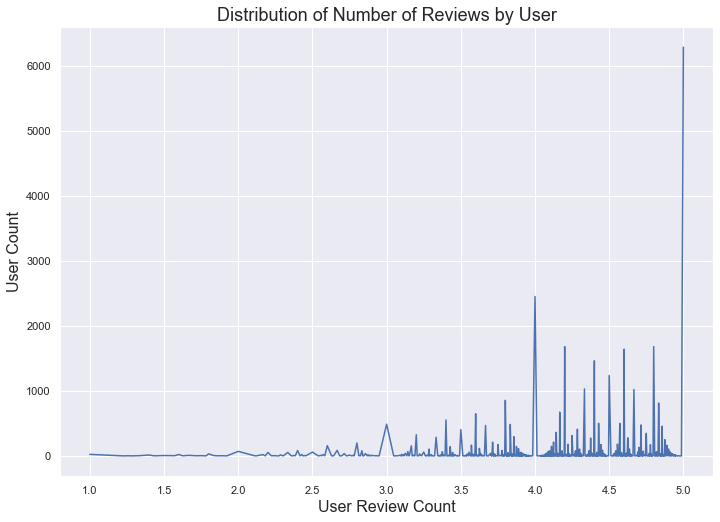

In [19]:
distribution_per_user = merged_df.groupby('reviewerID').mean().overall.value_counts()

figure = sns.lineplot(x=distribution_per_user.index, y=distribution_per_user.values)
plt.title('Distribution of Number of Reviews by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('User Review Count', fontsize=16)
plt.ylabel('User Count', fontsize=16)
# plt.savefig(r"../images/dist_of_average_review_per_user");

Text(0, 0.5, 'Product Review Mean')

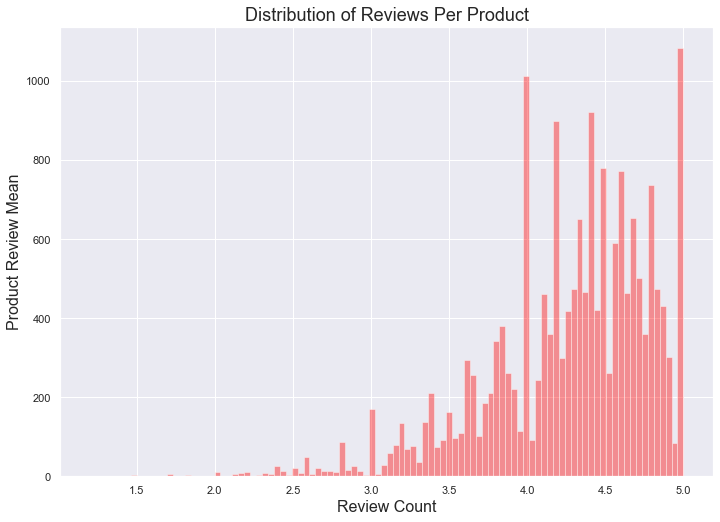

In [22]:
distribution_of_reviews_per_item = merged_df.groupby('asin').mean().overall.sort_values().tolist()



figure = sns.distplot(distribution_of_reviews_per_item, kde=False, color='red', bins=100)
plt.title('Distribution of Reviews Per Product', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Review Count', fontsize=16)
plt.ylabel('Product Review Mean', fontsize=16)
# plt.savefig(r"../images/dist_of_reviews_per_product");

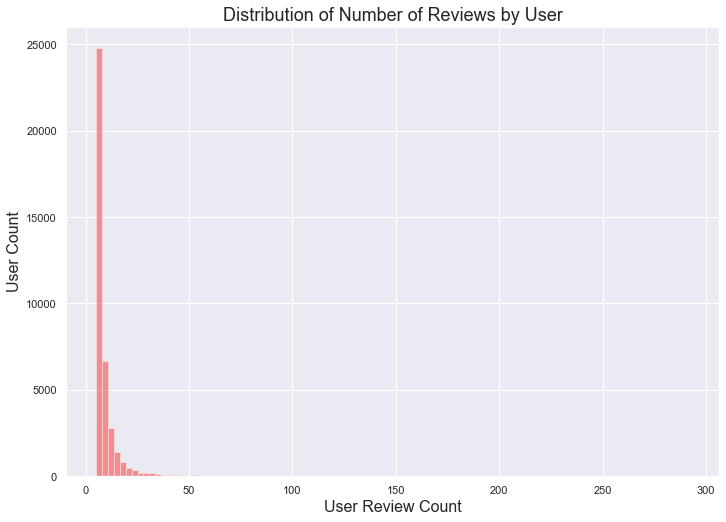

In [21]:
# Visualize the distribution of Review Counts

review_count = health_df.groupby('reviewerID').count()
figure = sns.distplot(review_count['asin'], kde=False, color='red', bins=100)
plt.title('Distribution of Number of Reviews by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('User Review Count', fontsize=16)
plt.ylabel('User Count', fontsize=16)
# plt.savefig(r"../images/dist_of_reviews");

In [23]:
# lets look at this with more detail
max = review_count['overall'].max()
min = review_count['overall'].min()
average = review_count['overall'].mean()
median = review_count['overall'].median()

print(f"The max number of reviews by user is {max} and the min number of reviews by user is {min}")
print(f"The average number of reviews by user is {average} and the median number of reviews by user is {median}")

The max number of reviews by user is 292 and the min number of reviews by user is 5
The average number of reviews by user is 8.970835815483436 and the median number of reviews by user is 6.0


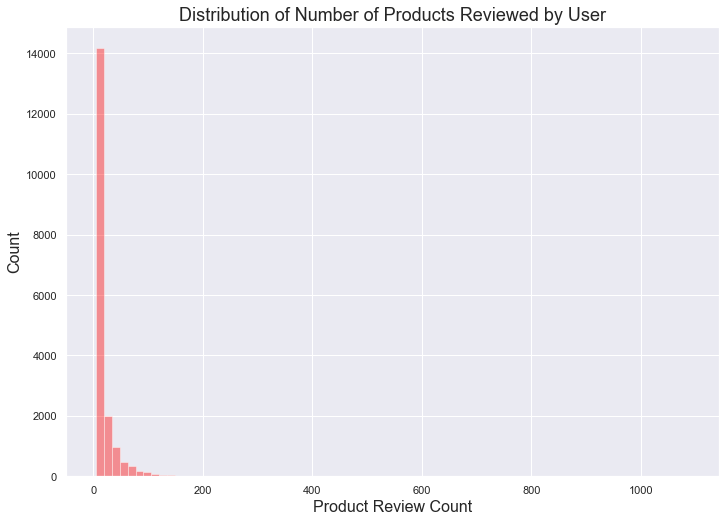

In [25]:
# Visualize the distribution of apps reviewed
prod_count = health_df.groupby('asin').count()

figure = sns.distplot(prod_count['reviewerID'], kde=False, color='red', bins=75)
plt.title('Distribution of Number of Products Reviewed by User', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Product Review Count', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/dist_of_prods");

In [26]:
# Lets look at this distribution in more detail
max = prod_count.reviewerID.max()
min = prod_count.reviewerID.min()
average = prod_count.reviewerID.mean()
median = prod_count.reviewerID.median()

print(f"The max number of reviews for apps is {max} and the min number of reviews for apps is {min}")
print(f"The average number of reviews for apps is {round(average, 3)} and the median number of reviews for apps is {median}")

The max number of reviews for apps is 1089 and the min number of reviews for apps is 5
The average number of reviews for apps is 18.688 and the median number of reviews for apps is 9.0


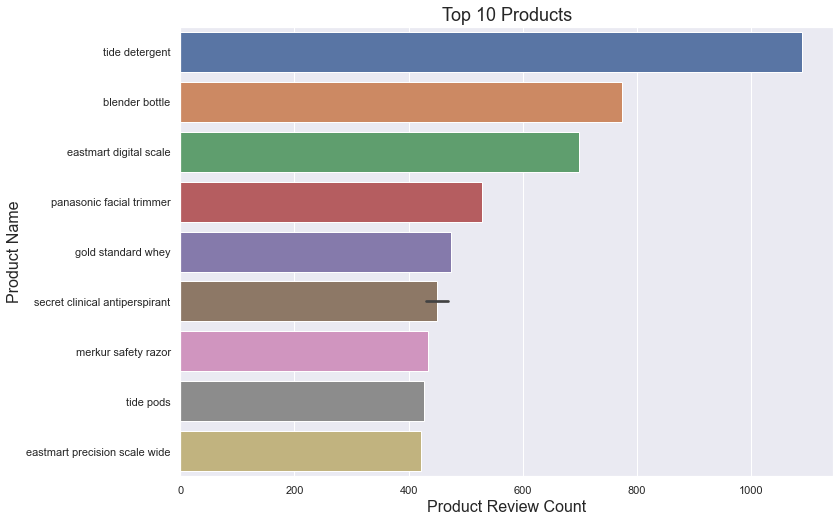

In [40]:
# top 10 most reviewed products
# ax = sns.barplot(x="tip", y="day", data=tips)

# top 10 apps
top_10_reviewed_products = merged_df.groupby('title').count().sort_values(by='reviewerID', ascending=False)['reviewerID'][1:11]

top_10_reviewed_products.index = ['tide detergent', 'blender bottle', 'eastmart digital scale', 'panasonic facial trimmer', 'gold standard whey',
                                 'secret clinical antiperspirant', 'merkur safety razor', 'secret clinical antiperspirant', 
                                 'tide pods', 'eastmart precision scale wide']

# idx_list = top_10_reviewed_apps.index.tolist()
figure = sns.barplot(x=top_10_reviewed_products, y=top_10_reviewed_products.index)
plt.title('Top 10 Products', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Product Review Count', fontsize=16)
plt.ylabel('Product Name', fontsize=16)
# plt.savefig(r"../images/top_10_prods");

In [10]:
top_10_cats = merged_df.groupby('categories').count().sort_values(by='asin', ascending=False)['asin'][:10]
top_10_cats

categories
personal-care-removal-manual-shaving-hair                              9741
dietary-herbal-vitamins-supplements                                    6406
vitamins-prenatal-multiple-multi-dietary-vitaminmineral-supplements    6105
personal-trimmers-clippers-care-removal-shaving-hair                   5628
vitamins-digestive-dietary-fibers-supplements                          5094
massage-relaxation-care-oils-health-aromatherapy                       4882
plastic-tissue-bath-supplies-paper-household                           3981
liquid-detergent-supplies-laundry-household                            3853
personal-deodorants-care-combination-antiperspirants                   3648
medicine-care-allergy-asthma-sinus-health                              3597
Name: asin, dtype: int64

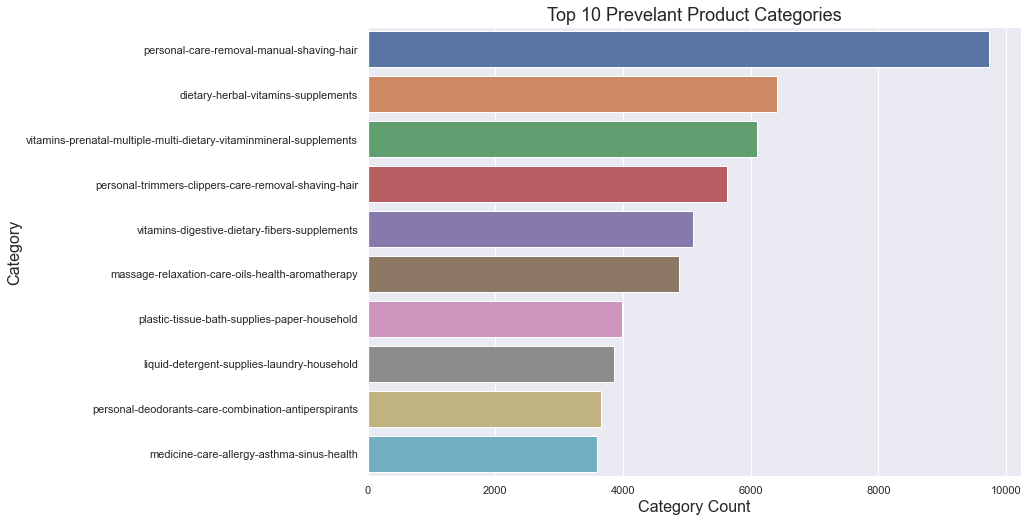

In [11]:
figure = sns.barplot(x=top_10_cats, y=top_10_cats.index)
plt.title('Top 10 Prevelant Product Categories', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Category Count', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.savefig(r"../images/top_10_cats_2");

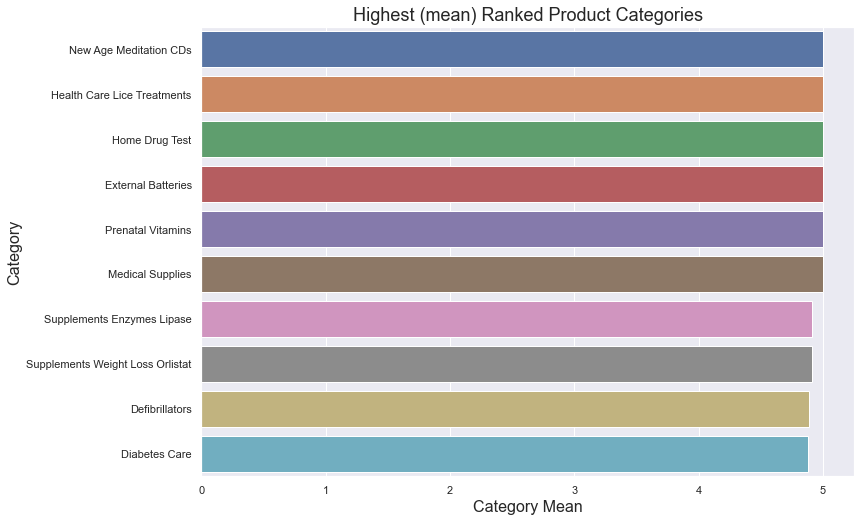

In [8]:
highest_rank = merged_df.groupby('categories').mean().sort_values(by='overall', ascending=False)['overall'][:10]
highest_rank.index = ['New Age Meditation CDs', 'Health Care Lice Treatments', 'Home Drug Test', 'External Batteries', 'Prenatal Vitamins', 
                     'Medical Supplies', 'Supplements Enzymes Lipase', 'Supplements Weight Loss Orlistat', 
                     'Defibrillators', 'Diabetes Care']

figure = sns.barplot(x=highest_rank, y=highest_rank.index)
plt.title('Highest (mean) Ranked Product Categories', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Category Mean', fontsize=16)
plt.ylabel('Category', fontsize=16)
# plt.savefig(r"../images/top_10_cats");

In [66]:
merged_df['reviewTime'] = pd.to_datetime(merged_df['reviewTime'])
review_time = merged_df.groupby('reviewTime').count()['reviewerID'][5:]

In [67]:
review_time

reviewTime
2001-07-15      1
2001-08-14      1
2001-09-24      1
2001-12-19      1
2002-01-01      1
             ... 
2014-07-19    121
2014-07-20    172
2014-07-21    238
2014-07-22    184
2014-07-23     21
Name: reviewerID, Length: 3386, dtype: int64

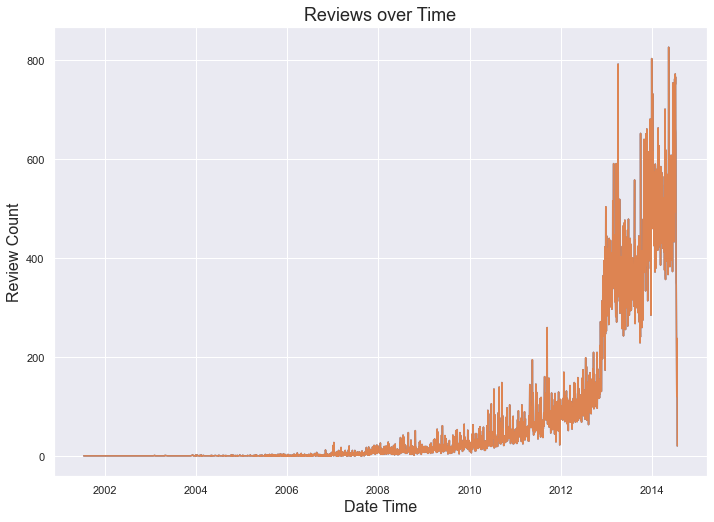

In [69]:
sns.lineplot(x=review_time.index, y=review_time)

figure = sns.lineplot(x=review_time.index, y=review_time)
plt.title('Reviews over Time', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Date Time', fontsize=16)
plt.ylabel('Review Count', fontsize=16)
# plt.savefig(r"../images/Reviews_time.png");

In [17]:
merged_df.groupby('reviewer_cat').count()['reviewerID'].sort_values()

reviewer_cat
shaving                13797
prenatal               22355
weight_loss            26805
protien_supplements    28604
deoderant              31783
massage                35765
vitamins               38745
laundry                44070
scale                  49486
alergy                 54945
Name: reviewerID, dtype: int64

Text(0, 0.5, 'Category')

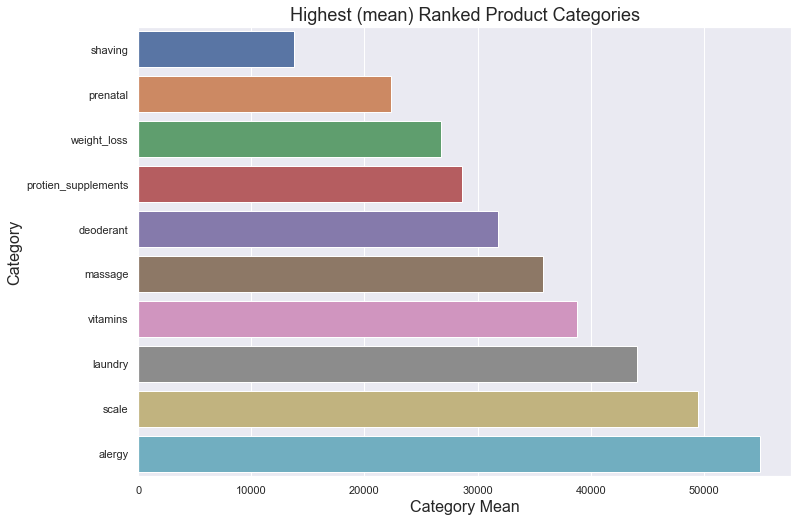

In [18]:
highest_rank = merged_df.groupby('reviewer_cat').count()['reviewerID'].sort_values()
# highest_rank.index = ['New Age Meditation CDs', 'Health Care Lice Treatments', 'Home Drug Test', 'External Batteries', 'Prenatal Vitamins', 
#                      'Medical Supplies', 'Supplements Enzymes Lipase', 'Supplements Weight Loss Orlistat', 
#                      'Defibrillators', 'Diabetes Care']

figure = sns.barplot(x=highest_rank, y=highest_rank.index)
plt.title('Highest (mean) Ranked Product Categories', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Category Mean', fontsize=16)
plt.ylabel('Category', fontsize=16)
# plt.savefig(r"../images/top_10_cats");